# Customer Churn Analysis

**Objective:**  
This notebook performs **data preparation and exploratory data analysis (EDA)** for the Customer Churn dataset.  

We will:
1. Load the dataset
2. Inspect data quality
3. Handle missing values
4. Encode categorical features
5. Perform EDA to understand patterns and relationships

In [72]:
# -------------------------------
# 01_data_preparation_and_eda.ipynb
# Setup & Imports
# -------------------------------

# Basic packages
import numpy as np
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")

## Load Dataset

We load the dataset into a pandas DataFrame and check its dimensions and first few rows to confirm it is loaded correctly.

In [73]:
# Load the dataset
file_path = "../../Data_Preparation/Raw_Data/Dataset_ATS_v2.csv"
data = pd.read_csv(file_path) # Update the path as needed
# Check dataset shape
print("Dataset shape:", data.shape)

# Preview first 5 rows
data.head()

Dataset shape: (7043, 10)


,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,InternetService,Contract,MonthlyCharges,Churn
0,Female,0,No,1,No,No,DSL,Month-to-month,25,Yes
1,Male,0,No,41,Yes,No,DSL,One year,25,No
2,Female,0,Yes,52,Yes,No,DSL,Month-to-month,19,No
3,Female,0,No,1,Yes,No,DSL,One year,76,Yes
4,Male,0,No,67,Yes,No,Fiber optic,Month-to-month,51,No


## Data Inspection

We check:
- Column names and data types
- Missing values
- Basic statistics

In [74]:
# Column names and data types
print("Columns and data types:")
print(data.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
data.describe()

Columns and data types:
gender               str
SeniorCitizen      int64
Dependents           str
tenure             int64
PhoneService         str
MultipleLines        str
InternetService      str
Contract             str
MonthlyCharges     int64
Churn                str
dtype: object

Missing values per column:
gender             0
SeniorCitizen      0
Dependents         0
tenure             0
PhoneService       0
MultipleLines      0
InternetService    0
Contract           0
MonthlyCharges     0
Churn              0
dtype: int64

Summary statistics:


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.758768
std,0.368612,24.559481,30.091650
min,0.000000,0.000000,18.000000
25%,0.000000,9.000000,36.000000
50%,0.000000,29.000000,70.000000
75%,0.000000,55.000000,90.000000
max,1.000000,72.000000,119.000000


### Step 4: Data Overview and Insights

**1. Columns and Data Types**
- Categorical: `gender`, `Dependents`, `PhoneService`, `MultipleLines`, `InternetService`, `Contract`, `Churn`
- Numeric: `SeniorCitizen`, `tenure`, `MonthlyCharges`
- Insight: Categorical variables need encoding before modeling.

**2. Missing Values**
- All columns have 0 missing values.
- Insight: Dataset is complete, no missing data handling required.

**Insights:**
- `SeniorCitizen` is highly imbalanced (mostly 0, ~16% are seniors).
- `tenure` ranges from 0 to 72 months, with some very low or very high values. Scaling is required.
- `MonthlyCharges` has high variance; scaling is necessary to prevent domination in distance-based models.
- Potential outliers exist in `tenure` and `MonthlyCharges`, which may affect clustering.

**4. Next Steps**
- Apply scaling to numeric features (`tenure` and `MonthlyCharges`).
- Encode categorical variables:
  - One-Hot Encoding: `InternetService`, `Contract`, `gender`
  - Binary/Label Encoding: `SeniorCitizen`, `Dependents`, `PhoneService`, `MultipleLines`, `Churn`
- Check feature correlations and distributions to confirm no extreme bias before clustering.

## Step 5: Data Preprocessing

### 1. Encoding Categorical Variables
- `gender` → One-Hot Encoding  
  - Nominal variable, no ordinal relationship. Avoids introducing artificial hierarchy.  
- `InternetService`, `Contract` → One-Hot Encoding  
  - Multiple categories with no natural order. Prevents bias in distance-based models.  
- `SeniorCitizen`, `Dependents`, `PhoneService`, `MultipleLines`, `Churn` → Label/Binary Encoding  
  - Binary categories (Yes/No, 0/1). Encoding into 0/1 is sufficient.  

### 2. Scaling Numeric Features
- `tenure`, `MonthlyCharges` → StandardScaler  
  - K-Means uses distance metrics. Scaling ensures equal contribution of each numeric variable.  
  - Other numeric features not scaled because only `tenure` and `MonthlyCharges` are continuous and relevant for clustering.  

### 3. Outliers & Distribution Check
- Boxplots and histograms used for `tenure` and `MonthlyCharges`.  
- Detects extreme values that may distort clustering centroids.  

### 4. Justification
- Encoding choices prevent false numerical ordering.  
- Scaling ensures numeric features are comparable in clustering.  
- Preprocessing decisions improve model reliability and interpretability.

In [75]:
# ---- 1. Encoding Categorical Variables ----
# Binary/Label Encoding
binary_cols = ['SeniorCitizen', 'Dependents', 'PhoneService', 'MultipleLines', 'Churn']
le = LabelEncoder()
for col in binary_cols:
    data[col] = le.fit_transform(data[col])

# One-Hot Encoding
one_hot_cols = ['gender', 'InternetService', 'Contract']
data = pd.get_dummies(data, columns=one_hot_cols,dtype=int)

# ---- 2. Scaling Numeric Features ----
scaler = StandardScaler()
numeric_cols = ['tenure', 'MonthlyCharges']
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# ---- 3. Quick check ----
print(data.head())
print(data.info())
data.head()

   SeniorCitizen  Dependents    tenure  PhoneService  MultipleLines  \
0              0           0 -1.277445             0              0   
1              0           0  0.351370             1              0   
2              0           1  0.799294             1              0   
3              0           0 -1.277445             1              0   
4              0           0  1.410099             1              0   

   MonthlyCharges  Churn  gender_Female  gender_Male  InternetService_DSL  \
0       -1.321350      1              1            0                    1   
1       -1.321350      0              0            1                    1   
2       -1.520755      0              1            0                    1   
3        0.373593      1              1            0                    1   
4       -0.457261      0              0            1                    0   

   InternetService_Fiber optic  Contract_Month-to-month  Contract_One year  \
0                            0  

,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,MonthlyCharges,Churn,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year
0,0,0,-1.277445,0,0,-1.321350,1,1,0,1,0,1,0,0
1,0,0,0.351370,1,0,-1.321350,0,0,1,1,0,0,1,0
2,0,1,0.799294,1,0,-1.520755,0,1,0,1,0,1,0,0
3,0,0,-1.277445,1,0,0.373593,1,1,0,1,0,0,1,0
4,0,0,1.410099,1,0,-0.457261,0,0,1,0,1,1,0,0


In [76]:
# Define the new column order
cols = ['gender_Female', 'gender_Male', 'SeniorCitizen', 'Dependents', 'tenure', 
        'PhoneService', 'MultipleLines', 'InternetService_DSL', 'InternetService_Fiber optic', 
        'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 
        'MonthlyCharges', 'Churn']

# Reorder the dataframe
data = data[cols]

# Quick check
data.head()

,gender_Female,gender_Male,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,MonthlyCharges,Churn
0,1,0,0,0,-1.277445,0,0,1,0,1,0,0,-1.321350,1
1,0,1,0,0,0.351370,1,0,1,0,0,1,0,-1.321350,0
2,1,0,0,1,0.799294,1,0,1,0,1,0,0,-1.520755,0
3,1,0,0,0,-1.277445,1,0,1,0,0,1,0,0.373593,1
4,0,1,0,0,1.410099,1,0,0,1,1,0,0,-0.457261,0


Missing Values per Column:
 gender_Female                  0
gender_Male                    0
SeniorCitizen                  0
Dependents                     0
tenure                         0
PhoneService                   0
MultipleLines                  0
InternetService_DSL            0
InternetService_Fiber optic    0
Contract_Month-to-month        0
Contract_One year              0
Contract_Two year              0
MonthlyCharges                 0
Churn                          0
dtype: int64


Data Types:
 gender_Female                    int64
gender_Male                      int64
SeniorCitizen                    int64
Dependents                       int64
tenure                         float64
PhoneService                     int64
MultipleLines                    int64
InternetService_DSL              int64
InternetService_Fiber optic      int64
Contract_Month-to-month          int64
Contract_One year                int64
Contract_Two year                int64
MonthlyCharges

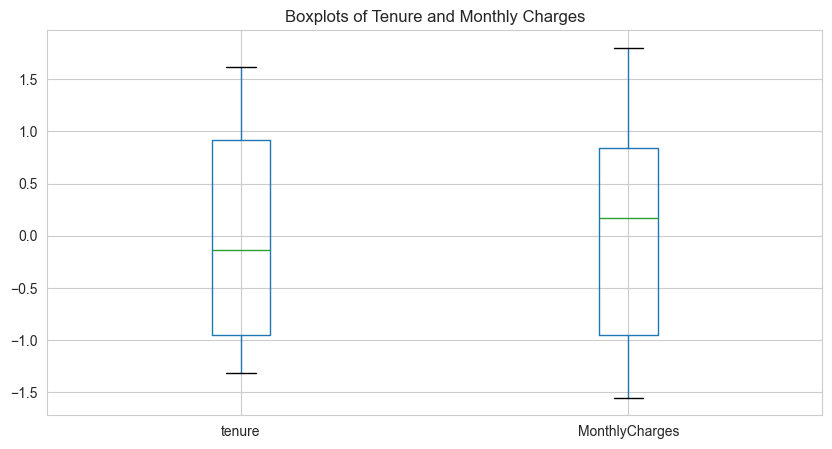

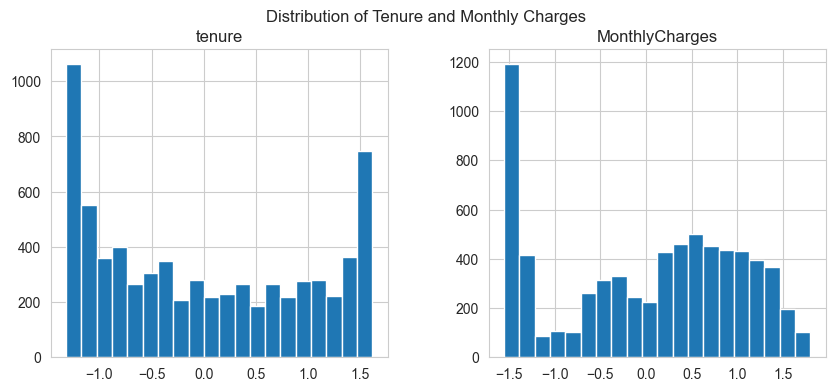

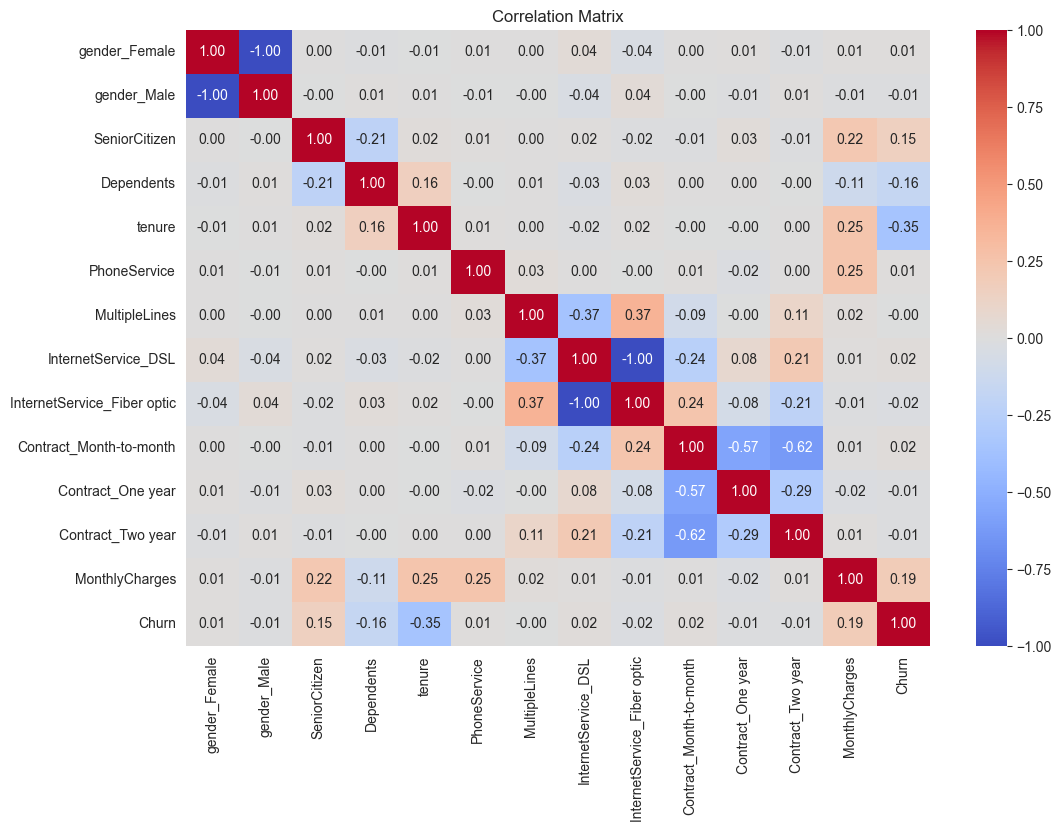

In [77]:
#-----Check befor move to further analysis ----------
# ---- 1. Missing Values ----
print("Missing Values per Column:\n", data.isnull().sum())
print("\n")

# ---- 2. Data Types ----
print("Data Types:\n", data.dtypes)
print("\n")

# ---- 3. Descriptive Statistics ----
print("Summary Statistics:\n", data.describe())
print("\n")

# ---- 4. Churn Distribution ----
print("Churn Class Balance:\n", data['Churn'].value_counts(normalize=True))
print("\n")

# ---- 5. Boxplots for Continuous Features ----
plt.figure(figsize=(10,5))
data[['tenure', 'MonthlyCharges']].boxplot()
plt.title("Boxplots of Tenure and Monthly Charges")
plt.show()

# ---- 6. Histograms for Continuous Features ----
data[['tenure', 'MonthlyCharges']].hist(bins=20, figsize=(10,4))
plt.suptitle("Distribution of Tenure and Monthly Charges")
plt.show()

# ---- 7. Correlation Matrix ----
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Boxplots: tenure and MonthlyCharges are scaled, no extreme outliers that can distort clustering.

Histograms: tenure has many new and long-term customers; MonthlyCharges is spread out. Scaling makes features comparable.

Correlation matrix: No strong multicollinearity; expected negative correlation between contract types and between DSL/Fiber optic.

Missing values: None — dataset is clean.

Churn balance: Imbalanced (73% no churn, 27% churn), note for interpreting clusters.

Data type & structure: All numeric after encoding; ready for clustering.

Basically, the dataset is clean, numeric, scaled, and ready for clustering analysis.

In [78]:
# ----- Save the cleaned dataset for future use -----
cleaned_file_path = "../../Data_Preparation/processed_data/preprocessed_telecom_churn.csv"
data.to_csv(cleaned_file_path, index=False)

# -----------------------------
# 4. Split Dataset
# -----------------------------
X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 5. Save Processed Data
# -----------------------------
processed_folder = "../../Data_Preparation/processed_data"

# Create folder if it doesn't exist
os.makedirs(processed_folder, exist_ok=True)

X_train.to_csv(os.path.join(processed_folder, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(processed_folder, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(processed_folder, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(processed_folder, "y_test.csv"), index=False)

X_train.head()
y_train.head()
X_test.head()
y_test.head()


456     0
2301    0
2256    0
4524    0
3777    0
Name: Churn, dtype: int64